# Visualize the Bader charges on the MP and OQMD collations individually (note: BEFORE spectra are matched in).
Goals: Audit of the bader charges stored in the MP and OQMD structures.

In [1]:
from pymatgen.ext.matproj import MPRester
from pymatgen.core import Structure
from pymatgen.analysis.structure_matcher import StructureMatcher, ElementComparator
from trixs.spectra.core import XAS_Spectrum, XAS_Collation
from trixs.spectra.util import NumpyEncoder
from tqdm import tqdm, tqdm_notebook
from pprint import pprint
import json
import os
import numpy as np
import scipy.stats as scistat
from pymatgen.analysis.local_env import CrystalNN

storage_directory = '/Users/steventorrisi/Documents/TRIXS/data/MP_OQMD_combined'
oqmd_bader_dir = '/Users/steventorrisi/Documents/TRIXS/data/OQMD_bader'
matcher = StructureMatcher(comparator = ElementComparator())
api_key = '80n2gkFfpXbPxZJTxD'
mpr = MPRester(api_key)

In [2]:
target_elements_groups=[('Co','O'),('Fe','O'),('V','O'),('Cu','O'),
                        ('Ni','O'),('Cr','O'),('Mn','O'),('Ti','O')]
target_metals = set(['Co','Ni','Fe','Cr','V','Mn','Cu','Ti'])
target_elements_sets =[set(pair) for pair in target_elements_groups]

def trim_non_alpha(string):
    target = ''
    for x in [x for x in string if x.isalpha()]:
        target+=x
    return target

In [3]:
mp_cols = {pair: [] for pair in target_elements_groups}
oqmd_cols  = {pair: [] for pair in target_elements_groups}
for pair in tqdm_notebook(target_elements_groups):
    collation_file = storage_directory+ "/{}_{}_".format(pair[0],pair[1])+'collations.json'

    with open(collation_file,'r') as f:
        for line in f.readlines():
            cur_dict = json.loads(line.strip())
            col = XAS_Collation.from_dict(cur_dict)
            #print([str(x) for x in col.structure.species])
            col.elements = set([trim_non_alpha(str(elt)) for elt in col.structure.species])
            #print(col.elements)
            if col.mp_id:
                mp_cols[pair].append(col)
            else:
                oqmd_cols[pair].append(col)
                

In [4]:
print(col.coordination_numbers)
print(cur_dict)



[6, 6, 6, 6, 6, 6]
{'@module': 'trixs.spectra.core', '@class': 'XAS_Collation', '@version': None, 'structure': {'@module': 'pymatgen.core.structure', '@class': 'Structure', 'charge': None, 'lattice': {'matrix': [[2.869896, 0.0, 0.0], [-1.434948, 2.485402, 0.0], [0.0, 0.0, 7.217821]], 'a': 2.869896, 'b': 2.8698952706166825, 'c': 7.217821, 'alpha': 90.0, 'beta': 90.0, 'gamma': 120.00000840720816, 'volume': 51.48360029432864}, 'sites': [{'species': [{'element': 'F', 'occu': 1}], 'abc': [0.0, 0.0, 0.4999999307], 'xyz': [0.0, 0.0, 3.6089099998050047], 'label': 'F', 'properties': {}}, {'species': [{'element': 'Li', 'occu': 1}], 'abc': [0.6666658883, 0.3333303828, 0.3423332333], 'xyz': [1.434950000030522, 0.8284600000718856, 2.470900000310639], 'label': 'Li', 'properties': {}}, {'species': [{'element': 'Li', 'occu': 1}], 'abc': [0.3333344063, 0.6666688125, 0.6576666282], 'xyz': [1.43494771620567e-10, 1.656939999925125, 4.746920000021152], 'label': 'Li', 'properties': {}}, {'species': [{'eleme

### Oxidation Audit

In [5]:
overlap = []

for pair in target_elements_groups:
    for col in mp_cols[pair]:
        if col.has_mp_oxy() and col.has_oqmd_oxy():
            overlap.append(col)
            
print(len(overlap))

1175


In [6]:
import matplotlib.pyplot as plt
import numpy as np
#for a in overlap:
#    print(a.mp_oxy)
#    print(a.oqmd_oxy)
#    print('---')

for pair in overlap:
    mp_bader = -1*np.array([ox[1] for ox in pair.mp_oxy])
    oqmd_bader = np.array([ox[1] for ox in pair.oqmd_oxy])
    plt.scatter(mp_bader,oqmd_bader)

plt.title("Parity Plot for OQMD / MP Bader Charge")
plt.xlabel("Materials Project Bader Chg")
plt.ylabel("-1 X OQMD Bader Chg")
plt.plot((-4,7),(-4,7))
plt.show()

#all_diffs = [np.mean(np.abs(np.add(pair.mp_oxy,pair.oqmd_oxy))) for pair in overlap]
#print(np.mean(all_diffs))

<Figure size 640x480 with 1 Axes>

In [7]:
mp_oxy_numbers = [sorted([-1*x[1] for x in pair.mp_oxy]) for pair in overlap]
oqmd_oxy_numbers = [sorted([x[1] for x in pair.oqmd_oxy]) for pair in overlap]



diffs = [np.abs(np.subtract(mp_oxy, oqmd_oxy)) for mp_oxy,oqmd_oxy in zip(mp_oxy_numbers,oqmd_oxy_numbers)]

maximal_diffs = [np.max(diff) for diff in diffs]
#print('Maxmial diff in bader occurs at index {} and is:',maximal_diffs.index(max(maximal_diffs)))
sorted_diffs = sorted(maximal_diffs)
largest = sorted_diffs[-1]
second_largest = sorted_diffs[-2]
third_largest = sorted_diffs[-3]
fourth_largest = sorted_diffs[-4]

#print(largest)
#print(second_largest)
#print(third_largest)
#print(fourth_largest)

#print(overlap[67].elements)
#largest_overlap = overlap[67]
#print(overlap[maximal_diffs.index(largest)].elements)
#print(overlap[maximal_diffs.index(second_largest)].elements)
#print(overlap[maximal_diffs.index(second_largest)].mp_id)

##print(overlap[maximal_diffs.index(third_largest)].elements)
#print(overlap[maximal_diffs.index(fourth_largest)].elements)



0.07132688322488738


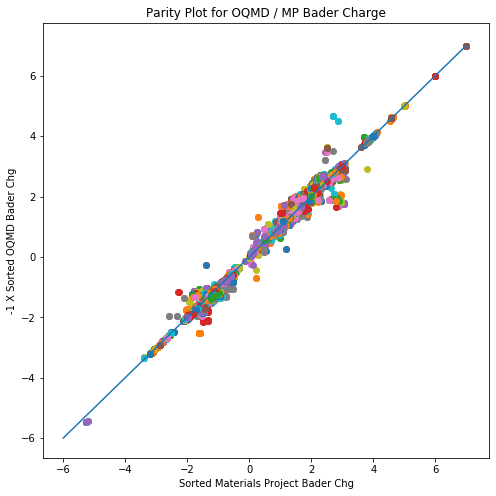

In [8]:
import matplotlib.pyplot as plt
import numpy as np
#for a in overlap:
#    print(a.mp_oxy)
#    print(a.oqmd_oxy)
#    print('---')
fig = plt.figure(figsize=(8,8))
all_mps = []
all_oqmds = []
for pair in overlap:
    mp_bader = np.array(sorted([-1*ox[1] for ox in pair.mp_oxy]))
    oqmd_bader = np.array(sorted([ox[1] for ox in pair.oqmd_oxy]))
    all_mps+= sorted([-1*ox[1] for ox in pair.mp_oxy])
    all_oqmds += sorted([ox[1] for ox in pair.oqmd_oxy])
    plt.scatter(mp_bader, oqmd_bader)


difference = np.mean(np.abs(np.subtract(all_mps,all_oqmds)))
print(difference)
plt.title("Parity Plot for OQMD / MP Bader Charge")
plt.xlabel("Sorted Materials Project Bader Chg")
plt.ylabel("-1 X Sorted OQMD Bader Chg")
plt.plot((-6,7),(-6,7))

Statistics about range of bader charge values within a given element

In [9]:
print(target_metals)

{'Fe', 'Mn', 'Co', 'Ti', 'V', 'Cu', 'Cr', 'Ni'}


### Get a sense of the overall oxidation number landscape, using exlcusively the MP collations (that may or may not be OQMD matched)

/Users/steventorrisi/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/steventorrisi/.local/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


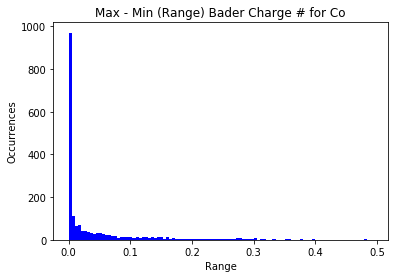

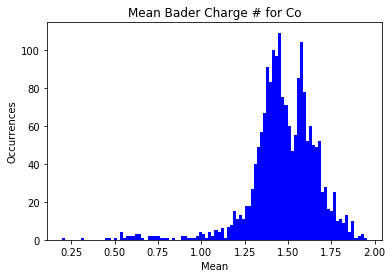

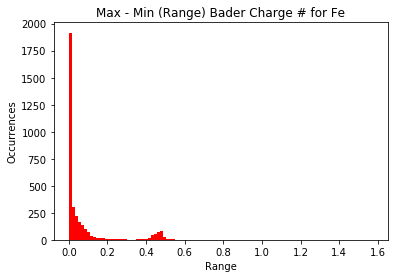

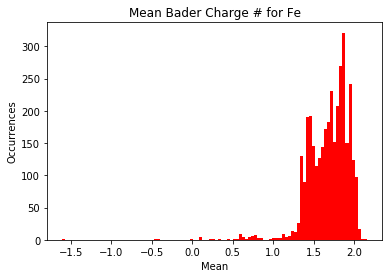

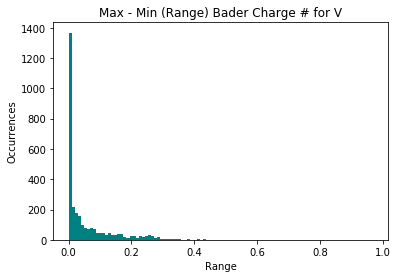

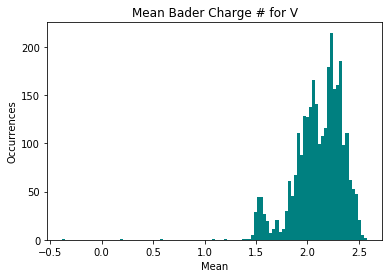

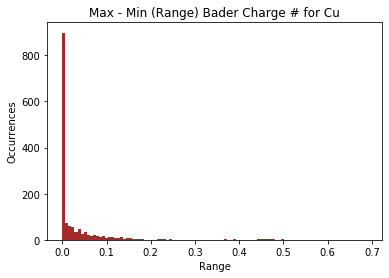

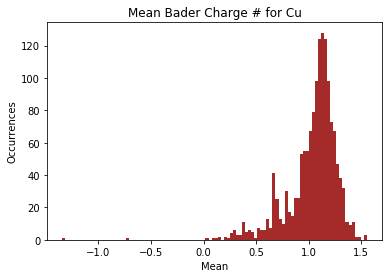

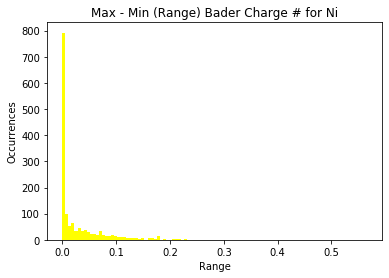

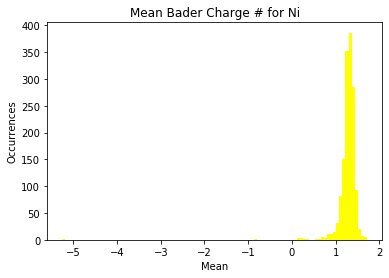

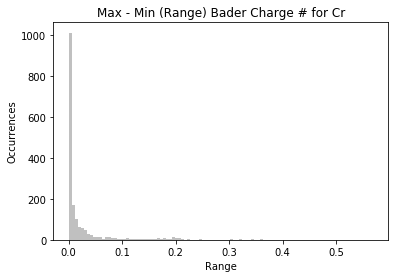

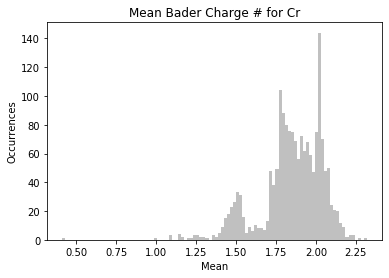

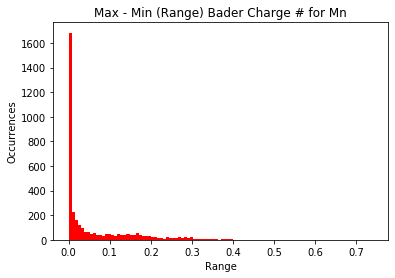

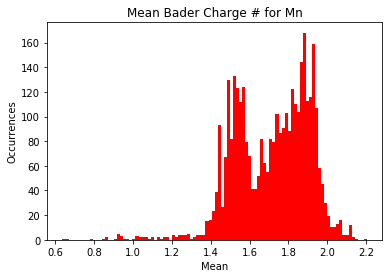

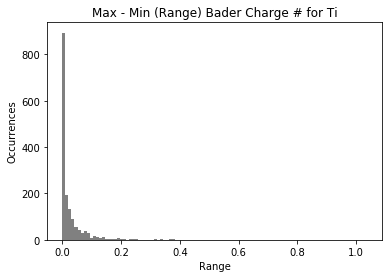

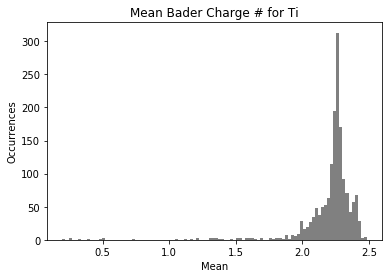

In [10]:
color_cycle = {'Cr':'silver','Mn':'red','Ti':'gray','V':'teal','Co':'blue','Fe':'red','Ni':'yellow','Cu':'brown'}
for pair in target_elements_groups:
    ranges = []
    stds = []
    means = []
    for col in [col for col in mp_cols[pair] if col.has_mp_oxy()]:
        #print(cur_mp_oxy)
        cur_mp_oxy = col.mp_oxy
        cur_species = set([oxy[0] for oxy in cur_mp_oxy])
        oxy_vals = {elt:[-1*oxy[1] for oxy in cur_mp_oxy if oxy[0]==elt] for elt in cur_species}
        #print(oxy_vals)
        oxy_stats = {elt: scistat.describe(oxy_vals[elt]) for elt in cur_species}
        elt = pair[0]
        ranges.append(max(oxy_vals[elt]) - min(oxy_vals[elt]))
        means.append(np.mean(oxy_vals[elt]))
        stds.append(np.std(oxy_vals[elt]))
        #print(oxy_stats)
    elt = pair[0]
    plt.title("Max - Min (Range) Bader Charge # for {}".format(elt))
    plt.hist(ranges,bins=100,color=color_cycle[elt])
    plt.xlabel("Range")
    plt.ylabel("Occurrences")
    plt.show()
    
    plt.title("Mean Bader Charge # for {}".format(elt))
    plt.hist(means,bins=100,color=color_cycle[elt])
    plt.xlabel("Mean")
    plt.ylabel("Occurrences")
    plt.show()
    
    #plt.title("Sigma Bader Charge # for {}".format(elt))
    #plt.hist(stds,bins=100,color=color_cycle[elt])
    ##plt.xlabel("Standard Deviation")
    #plt.ylabel("Occurrences")
    #plt.show()

## Compare the bader charges based on rounding against pymatgen's guess, and also sort by coordination number: only do for the structures with minimal range splitting

In [11]:
for pair in target_elements_groups:
    for col in tqdm_notebook([col for col in mp_cols[pair] if col.has_mp_oxy()]):
        break
pprint(col.as_dict())



{'@class': 'XAS_Collation',
 '@module': 'trixs.spectra.core',
 '@version': None,
 'coordination_numbers': [5, 5, 5, 5, 4, 6, 6, 6, 6],
 'feff_spectra': [],
 'icsd_ids': [77697, 174033],
 'mp_id': 'mp-10734',
 'mp_oxy': [['Ti', -1.7697179999999992],
            ['Ti', -1.7676850000000002],
            ['Ti', -1.767652],
            ['Ti', -1.7696850000000008],
            ['O', 1.4239420000000003],
            ['O', 1.4246049999999997],
            ['O', 1.4237349999999998],
            ['O', 1.4247430000000003],
            ['O', 1.377714]],
 'mp_spectra': [],
 'oqmd_id': 'oqmd-13999',
 'oqmd_oxy': [['O', -1.6444140000000003],
              ['O', -1.6514879999999996],
              ['O', -1.6463159999999997],
              ['O', -1.6496589999999998],
              ['O', -1.6542029999999999],
              ['Ti', 2.06273],
              ['Ti', 2.060301],
              ['Ti', 2.060301],
              ['Ti', 2.06273]],
 'structure': {'@class': 'Structure',
               '@module': 'pyma

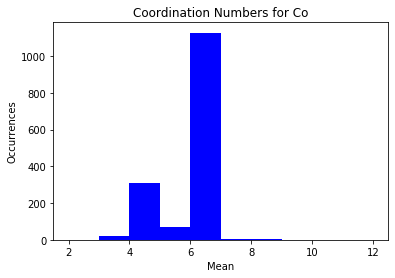

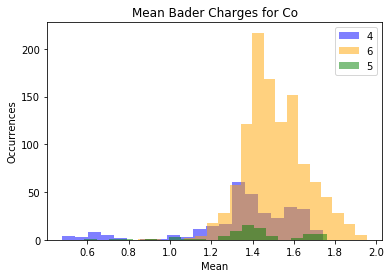

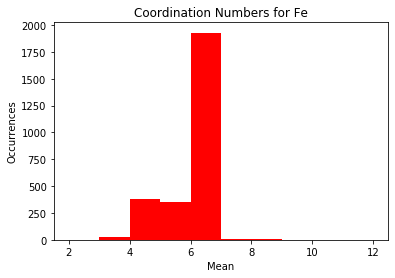

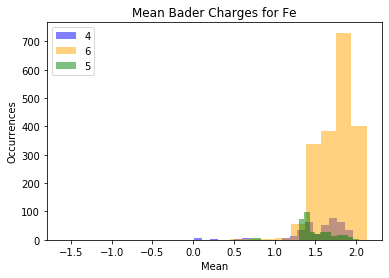

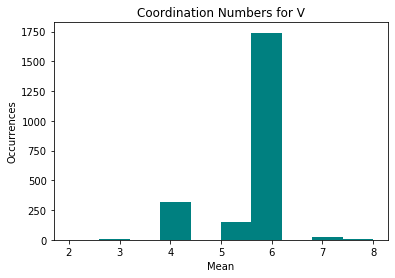

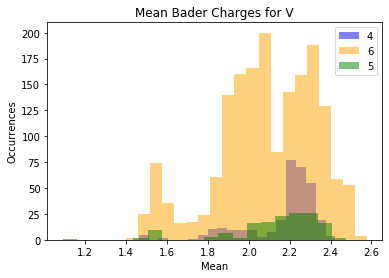

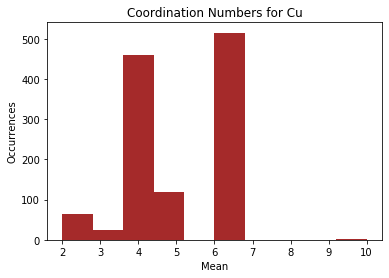

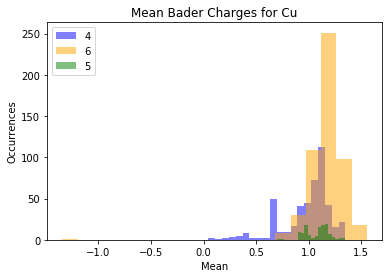

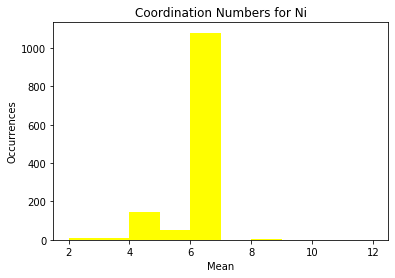

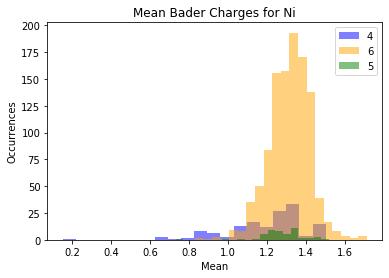

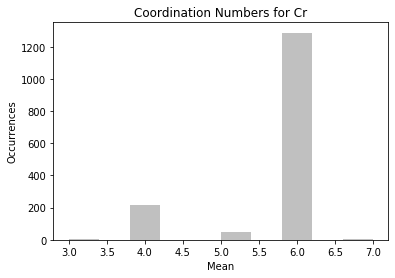

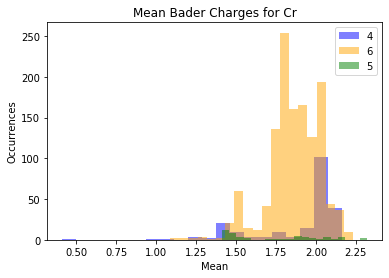

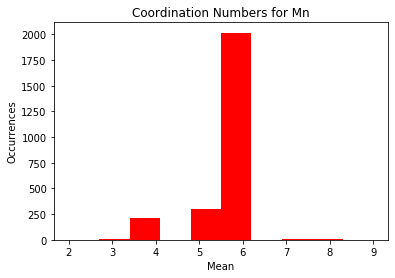

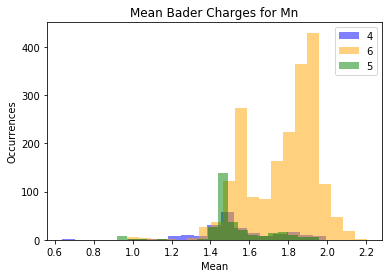

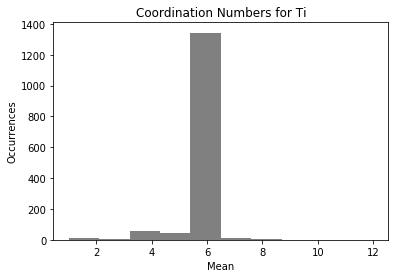

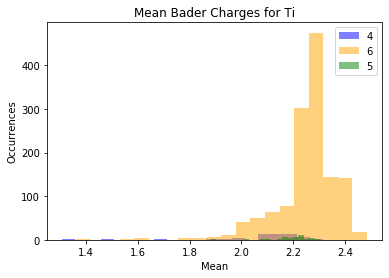

In [14]:
coord_colors = {4:'blue', 5:'green', 6:'orange'}

for pair in target_elements_groups:
    ranges = []
    stds = []
    means = []
    coords = []
    target_metal = pair[0]
    guessed_oxys = []
    multiple_coords_present = 0 
    guessed_means = []
    for col in tqdm_notebook([col for col in mp_cols[pair] if col.has_mp_oxy()],desc=str(pair)):
        cur_mp_oxy = col.mp_oxy
        cur_species = set([oxy[0] for oxy in cur_mp_oxy])
        oxy_vals = {elt:[-1*oxy[1] for oxy in cur_mp_oxy if oxy[0]==elt] for elt in cur_species}
        cur_range = max(oxy_vals[target_metal]) - min(oxy_vals[target_metal])
        
        if cur_range >.1 or len(col.coordination_numbers)==0:
            continue
        cur_sites = [site.as_dict()['species'][0]['element'] for site in col.structure.sites]
        metal_indices = [i for i in range(len(col.structure.sites)) if cur_sites[i]==target_metal]
        cur_coords = [col.coordination_numbers[i] for i in metal_indices]
        if len(set(cur_coords))>1 :
            multiple_coords_present+=1
            continue
        else:
            coords.append(cur_coords[0])
            #col.structure.add_oxidation_state_by_guess()
            #cur_oxy_guesses = [site.as_dict()['species'][0]['oxidation_state'] for site in col.structure.sites]
            #cur_oxy_guesses = [cur_oxy_guesses[i] for i in metal_indices]
            #guessed_oxys.append(cur_oxy_guesses)
            
        
        ranges.append(max(oxy_vals[target_metal]) - min(oxy_vals[target_metal]))
        #print(oxy_vals)
        oxy_stats = {elt: scistat.describe(oxy_vals[elt]) for elt in cur_species}
        elt = pair[0]
        means.append(np.mean(oxy_vals[elt]))
        #guessed_means.append(np.mean(guessed_oxys[-1]))

        stds.append(np.std(oxy_vals[elt]))
        #print(oxy_stats)
    elt = pair[0]
    
    #print(set([coord for coord in coords if isinstance(coord,int)]))
    means_by_coord = {coord:[] for coord in set(coords)}
    #guesses_by_coord = {coord:[] for coord in set(coords)}

    for i in range(len(means)):
        means_by_coord[coords[i]].append(means[i])
        #guesses_by_coord[coords[i]].append(guessed_means[i])
    #print(means)
    #print(coords)
    
    plt.title("Coordination Numbers for {}".format(elt))
    plt.hist(coords,color=color_cycle[elt])
    plt.xlabel("Mean")
    plt.ylabel("Occurrences")
    plt.show()
    
    plt.title("Mean Bader Charges for {}".format(elt))
    for coord in [4,6,5]:
        plt.hist(np.array(means_by_coord[coord]),bins=20,color=coord_colors[coord],alpha=.5,
                label=coord)
    plt.legend()
    plt.xlabel("Mean")
    plt.ylabel("Occurrences")
    plt.show()
    """           
    plt.title("Guessed Mean Oxy # for {}".format(elt))
    for coord in [4,6,5]:
        plt.hist(np.array(guesses_by_coord[coord]),bins=20,color=coord_colors[coord],alpha=.5,
                label=coord)
    plt.legend()
    plt.xlabel("Mean")
    plt.ylabel("Occurrences")
    plt.show()
    """     
    

## Proposal: Break ties by using guess based on coordination, or based on Formula?